## Basic setup and imports

In [1]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch

import numpy as np

import pandas as pd

In [2]:
from pylab import rcParams

In [3]:
import matplotlib.pyplot as plt

from matplotlib import rc
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

In [5]:
from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

Plots setups:

In [6]:
%matplotlib inline

%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [7]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Exploration

We'll be loading the Dataset and check wheter it is well balanced or not

In [8]:
df = pd.read_csv("reviews.csv")

df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [9]:
df.shape

(15746, 11)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


We're mostly interested in the score and review text in order to train our sentiment analysis model, so it's great that it has no missing values. Now let's check how balanced is the dataset

/home/caiotulio/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


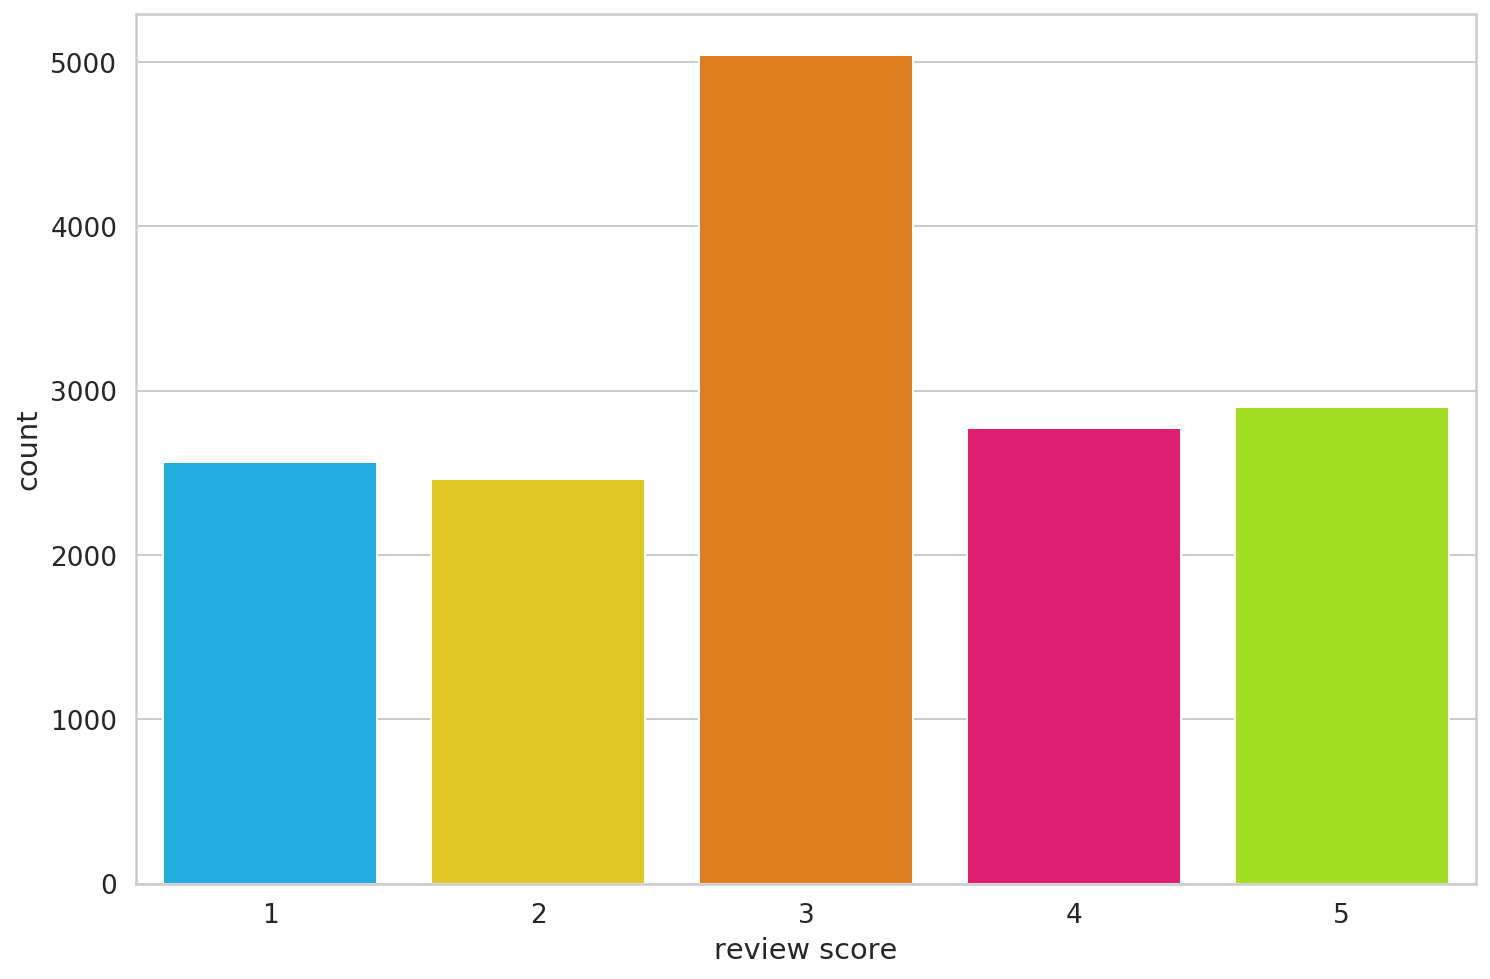

In [11]:
sns.countplot(df.score)

plt.xlabel('review score');

Because that's unbalanced, we map the 5 stars to something in [0,1,2] interval:

In [12]:
def to_sentiment(rating):

  rating = int(rating)

  if rating <= 2:

    return 0

  elif rating == 3:

    return 1

  else:

    return 2

df['sentiment'] = df.score.apply(to_sentiment)


/home/caiotulio/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


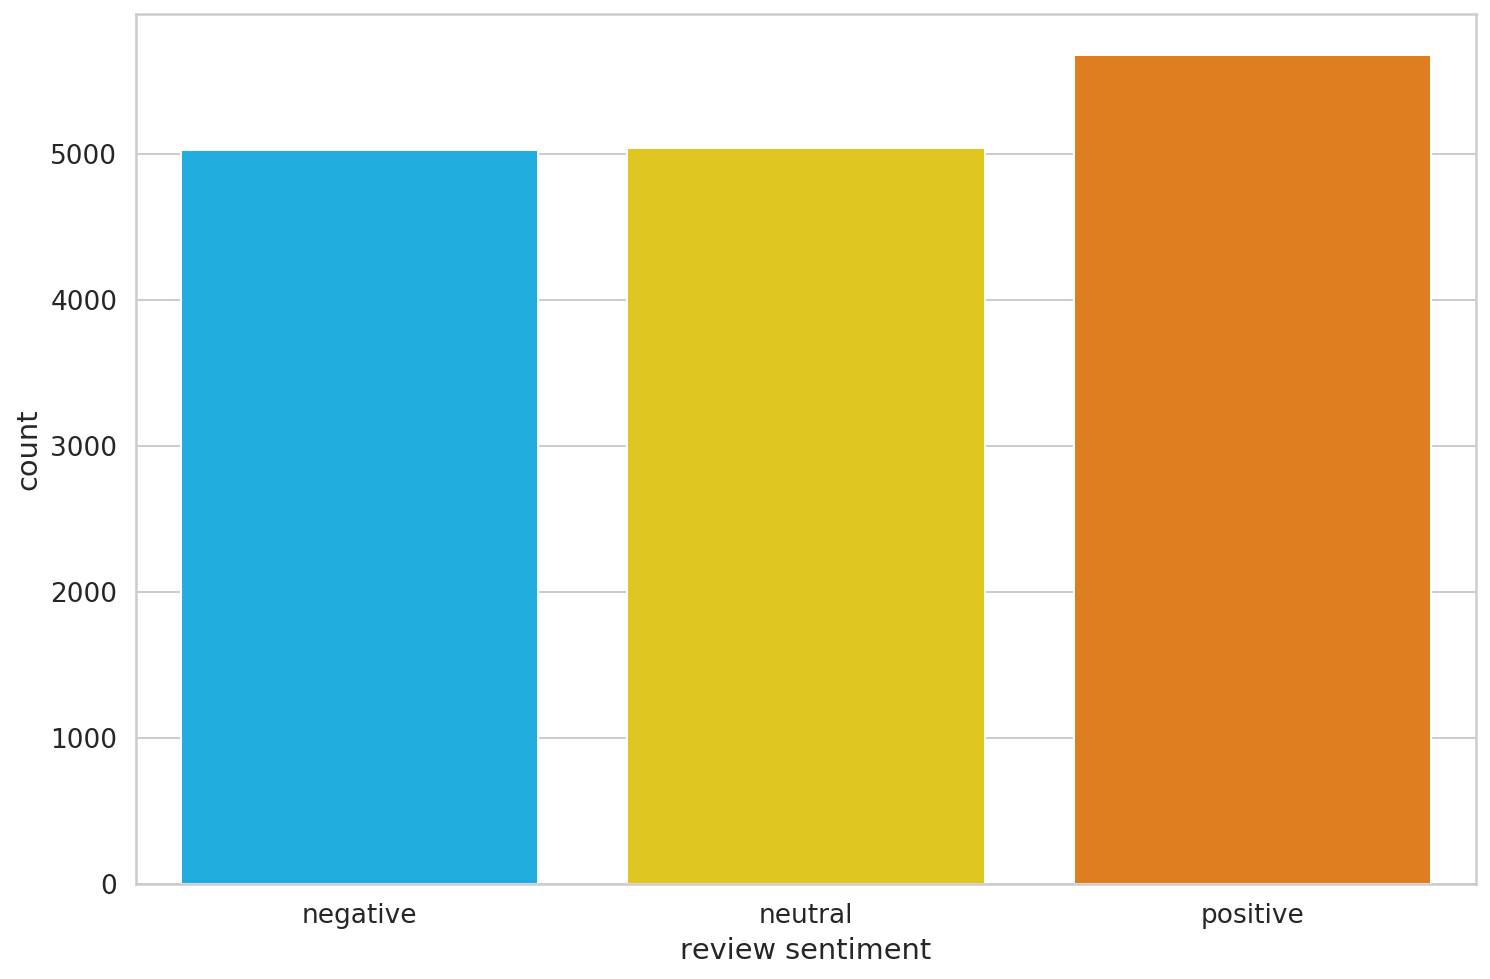

In [13]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)

plt.xlabel('review sentiment')

ax.set_xticklabels(class_names);

Much better :)

## Data preprocessing

As with most NLP tasks, our preprocessing will consist of:

1. Tokenizing
2. Embedding

First, let's load the tokenizer

In [14]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [15]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll perform now a sample tokenization

In [16]:
sample_txt = "When was i last outside? I am trying to remember"

In [17]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [18]:
print(f' Sentence: {sample_txt}')

print(f'   Tokens: {tokens}')

print(f'Token IDs: {token_ids}')

 Sentence: When was i last outside? I am trying to remember
   Tokens: ['When', 'was', 'i', 'last', 'outside', '?', 'I', 'am', 'trying', 'to', 'remember']
Token IDs: [1332, 1108, 178, 1314, 1796, 136, 146, 1821, 1774, 1106, 2676]


### BERT's special tokens

When tokenizing text, there are 4 tokens that are special:

* [SEP] : Marks the ending of a **sentence**
* [CLS]: Special token that defines the **sentence as a whole**. Useful for sentence level tasks
* [PAD]: Padding token. If we feed two sentences to BERT at the same time, they need to be of the same length. The PAD token does that for us
* [UNK]: Stands for unknown tokens.

For some tasks, some parts of the sentence shoould be ignored from computing the attention. That's where the attention mask comes in.

There's a incremented version of the tokenizer that receives not only the input text, but wheter if we should consider special tokens, the max length, and others


In [19]:
encoding = tokenizer.encode_plus(
  
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'

  return_token_type_ids=False, # A token type is a special token that defines from which sentence some token is derived from. We're not interested in that information here.
  pad_to_max_length=True,
  return_attention_mask=True,

  return_tensors='pt',  # Return PyTorch tensors

)
print(encoding['input_ids'][0])
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) # Encoding is a 2-d array of shape 32,1. That's why we access the first element. We could, however, have used array.flatten().

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


tensor([ 101, 1332, 1108,  178, 1314, 1796,  136,  146, 1821, 1774, 1106, 2676,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


/home/caiotulio/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


['[CLS]',
 'When',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'trying',
 'to',
 'remember',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [20]:
print(len(encoding['input_ids'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

With the two previous cells, we've show three things:

1. The input sentence with special tokens
2. The input was padded to 32 length sentences
3. The attention mask.

The attention mask is useful in this context because we don't want our classifier to derive any meaning from PAD tokens.

## Choosing Sequence length

BEcause BERT is a **Transformers based model**, it works with fixed-length sequences. By default (it was stablished on BERT's original paper), it padds its sentences for 512 length. But we can always analyse our input and check its average input lenght:

In [21]:
token_lens = []

for txt in df.content:

  tokens = tokenizer.encode(txt, max_length=512)

  token_lens.append(len(tokens))

/home/caiotulio/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

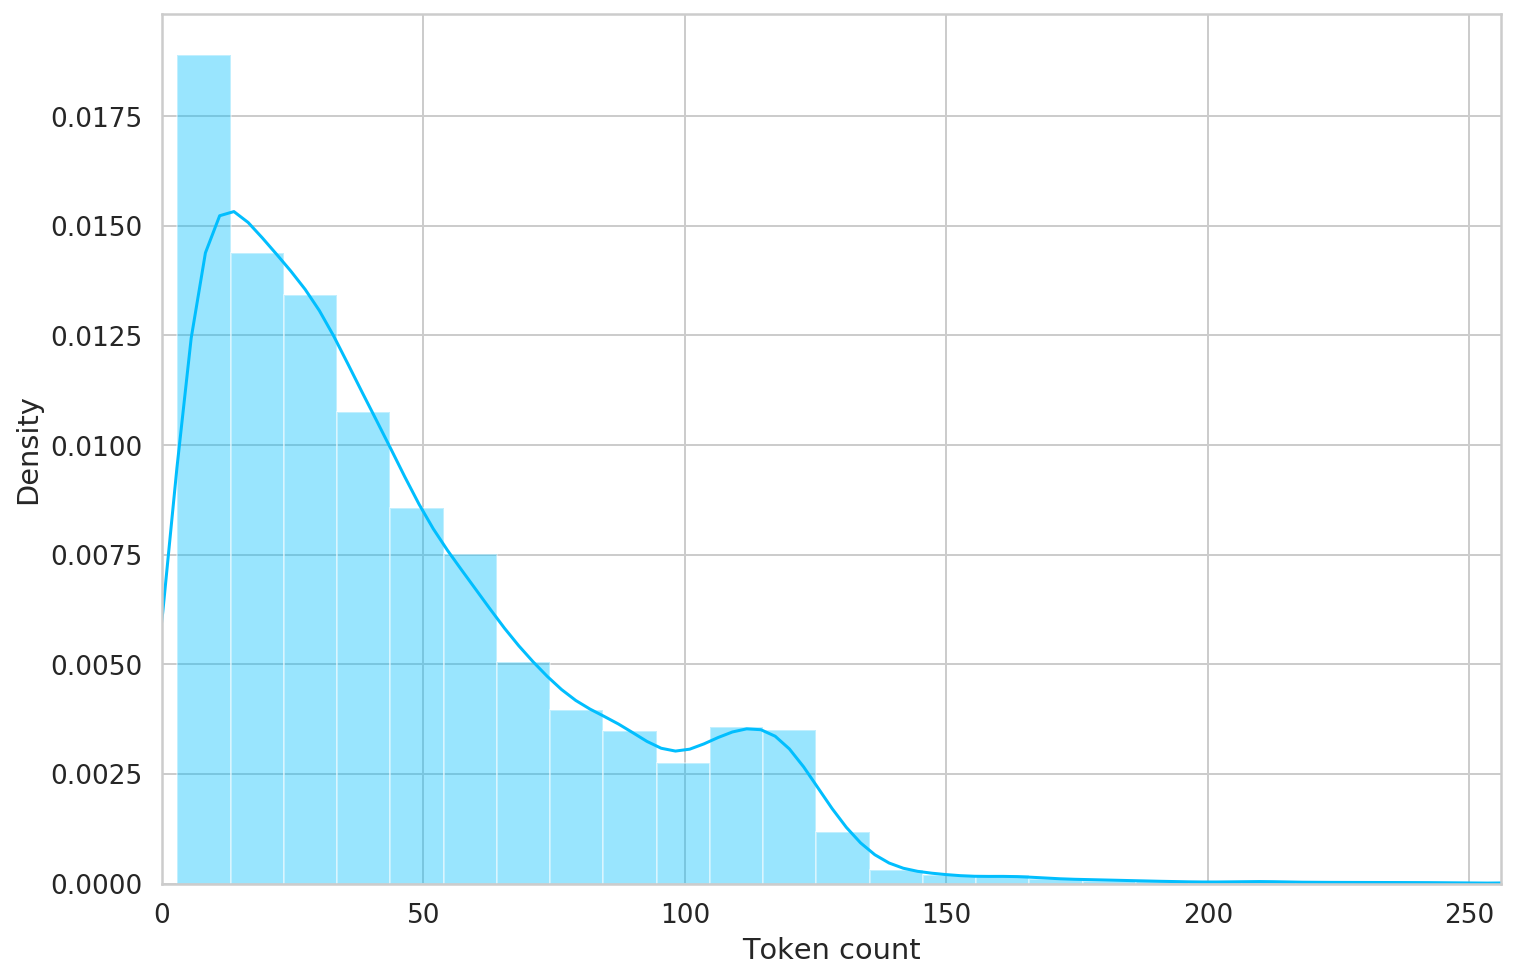

In [22]:
sns.distplot(token_lens)

plt.xlim([0, 256]);

plt.xlabel('Token count');

As we can see, it would be overkill to use a max length of 512. We will be fine with a max length of around 160.

In [23]:
MAX_LEN = 160

### Building a pytorch dataset

Every pytorch dataset must implement three methods: `__init__`, `__len__` and `__getitem__`:

In [24]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets # 5 star scale (which was scaled to [0,1,2]
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    

Now let's split the dataset:

In [25]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [26]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Now let's build a dataloader:


In [27]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews = df.content.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size, # We're going to load 16 examples at each turn
        num_workers=4
    )

In [28]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
data = next(iter(train_data_loader))
print(len(data['review_text'])) # Because batch size = 16, each data instance will contain 16 review texts, 16 embeddings, 16 attention masks and 16 targets
data.keys()

/home/caiotulio/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/caiotulio/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad

16


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


What that did was create a iterator in order to make it easier to iterate through our dataset. Each data entry is a 16x160 tensor, which contains 16 reviews padded to 160 caracters. And we'll try to predict a 16x1 tensor which contains the target sentiment of each review

## Sentiment analysis using BERT and Hugging Face

HuggingFace contains a lot of models that could be useful in this case, including a fine tuned model for Sentiment Analysis. But we're interested here in the process of fine tuning a model, so we'll use BERT's base model

In [31]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


It's worth mentioning the use of bert cased instead of bert uncased. Because we're deaeling with internet reviews where there is not a lot of commitment in writting formal text, we can encounter both 'Bad' and 'BAD' in a review. But 'BAD' conveys more meaning, so we want our model to be able to learn that.

Let's try using the model on the encoding of the sample text

In [32]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    return_dict=False
)

Where the last hidden state contains the internal representation of the sentenci in BERTs last hiddent state (in bert base, i think there are 16 layers of transformers, so that would be the 16th output), and `pulled_output` represents the representation of the sentence as a whole.

In [33]:
last_hidden_state.shape

torch.Size([1, 32, 768])

Notice that the output is a 1x32x768 tensor. the '1' dimension is due to we dealing with a single sentence, for `32` tokens with a 768 number of hidden units in the feedforward network:

In [34]:
bert_model.config.hidden_size

768

In [35]:
pooled_output.shape

torch.Size([1, 768])

As we said, the pooled output is kinda of a summary for the input.

### Building a classifier using BERT


In [36]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for regularization and a simple linear layer for the output. 

In [37]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
input_ids = data['input_ids'].to(device)

attention_mask = data['attention_mask'].to(device)

In [39]:
import torch.nn.functional as F

In [40]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1941, 0.4103, 0.3956],
        [0.1826, 0.3269, 0.4905],
        [0.3562, 0.3238, 0.3200],
        [0.3759, 0.2366, 0.3876],
        [0.3278, 0.3808, 0.2914],
        [0.1967, 0.4028, 0.4004],
        [0.3387, 0.2485, 0.4128],
        [0.2176, 0.2207, 0.5617],
        [0.2997, 0.2878, 0.4125],
        [0.1578, 0.4811, 0.3612],
        [0.2048, 0.2917, 0.5035],
        [0.3114, 0.3459, 0.3428],
        [0.1886, 0.4011, 0.4104],
        [0.2304, 0.2400, 0.5296],
        [0.2038, 0.2635, 0.5327],
        [0.4480, 0.2809, 0.2711]], grad_fn=<SoftmaxBackward>)

## Training

We'll be using `AdamW` as optimizer. Others parameters such as `learning rate` and number of epochs were derived from berts original paper

In [41]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

The function `get_linear_schedule_with_warmup` builds up the learning rate from - up to the given lr.

Now we'll write a function to train a single epoch:

In [47]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples):
    
    model = model.train() # Sets internal configurations to training mode
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1) #Gets the max prediction for some cattegory.
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step() #Increases the learning rate a little
        optimizer.zero_grad() # Avoids exploding gradient
        
    return correct_predictions.double() / n_examples, np.mean(losses)

Now let's build a helper function that evaluates the model on a data loader

In [50]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval() # Sets model to eval mode
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad(): # Disables gradient calculation. Reduces memory usage, useful if we're sure that we're not going to do gradient optimization.
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Finally, we can write our training loop:

In [49]:
%%time

history =  defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss}; Accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if (val_acc > best_accuracy):
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


/home/caiotulio/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/caiotulio/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad

KeyboardInterrupt: 